1. Setup

In [21]:
# --- 1. Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

# Load engineered features
df = pd.read_parquet("air_12318_features_full.parquet")

# Focus only on ON cycles
df_on = df[df['is_running'] == 1].copy()
print("Data shape (ON cycles):", df_on.shape)

# Select feature columns (drop ID/time-like fields)
feature_cols = [c for c in df_on.columns if c not in ['time','id','is_running']]
X = df_on[feature_cols].fillna(0).values


Data shape (ON cycles): (65154, 58)


Unsupervised Labels (Isolation Forest + One-Class SVM)

Isolation Forest

In [22]:
# --- 2. Isolation Forest ---
iso = IsolationForest(n_estimators=200, contamination=0.01, random_state=42)
df_on['anomaly_iforest'] = iso.fit_predict(X)

# Convert to 0=normal, 1=anomaly
df_on['anomaly_iforest'] = (df_on['anomaly_iforest'] == -1).astype(int)
print("IForest anomalies:", df_on['anomaly_iforest'].sum())


IForest anomalies: 652


One-Class SVM (⚠️ slow on big data, consider sampling)

In [23]:
# --- 3. One-Class SVM ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

ocsvm = OneClassSVM(nu=0.01, kernel="rbf", gamma="scale")
df_on['anomaly_ocsvm'] = ocsvm.fit_predict(X_scaled)
df_on['anomaly_ocsvm'] = (df_on['anomaly_ocsvm'] == -1).astype(int)

print("OC-SVM anomalies:", df_on['anomaly_ocsvm'].sum())


OC-SVM anomalies: 649


Heuristic Labels

In [24]:
# Check ranges first
print(df_on['temp_Degrees Celsius'].describe())
print(df_on['pf_anomaly'].describe())
print(df_on['fuel_%_roc'].describe())

# Reset heuristic column
df_on['anomaly_heuristic'] = 0

# Temperature rule: flag only top 1% hottest readings
temp_thresh = df_on['temp_Degrees Celsius'].quantile(0.99)
df_on.loc[df_on['temp_Degrees Celsius'] > temp_thresh, 'anomaly_heuristic'] = 1

# Power factor imbalance rule: top 1% worst imbalance
pf_thresh = df_on['pf_anomaly'].quantile(0.99)
df_on.loc[df_on['pf_anomaly'] > pf_thresh, 'anomaly_heuristic'] = 1

# Fuel drops: flag only sudden drops beyond 5th percentile
fuel_thresh = df_on['fuel_%_roc'].quantile(0.01)  # extreme negative
df_on.loc[df_on['fuel_%_roc'] < fuel_thresh, 'anomaly_heuristic'] = 1

print("Heuristic anomalies fixed:", df_on['anomaly_heuristic'].sum())


count    65154.000000
mean        41.054179
std         13.204829
min         20.000000
25%         31.000000
50%         40.000000
75%         51.000000
max         87.000000
Name: temp_Degrees Celsius, dtype: float64
count    65154.000000
mean        19.231866
std         36.867869
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         99.000000
Name: pf_anomaly, dtype: float64
count    65153.000000
mean         0.000153
std          1.856697
min        -40.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         40.000000
Name: fuel_%_roc, dtype: float64
Heuristic anomalies fixed: 1400


Visualize Anomalies Over Time

In [25]:
# --- 5. Compare agreement between methods ---
methods = ['anomaly_iforest','anomaly_ocsvm','anomaly_heuristic']
agreement = df_on[methods].mean()
print("Anomaly rates:\n", agreement)

# How often do methods agree?
df_on['agree'] = df_on[methods].sum(axis=1)
print(df_on['agree'].value_counts())


Anomaly rates:
 anomaly_iforest      0.010007
anomaly_ocsvm        0.009961
anomaly_heuristic    0.021488
dtype: float64
agree
0    62910
1     1850
2      331
3       63
Name: count, dtype: int64


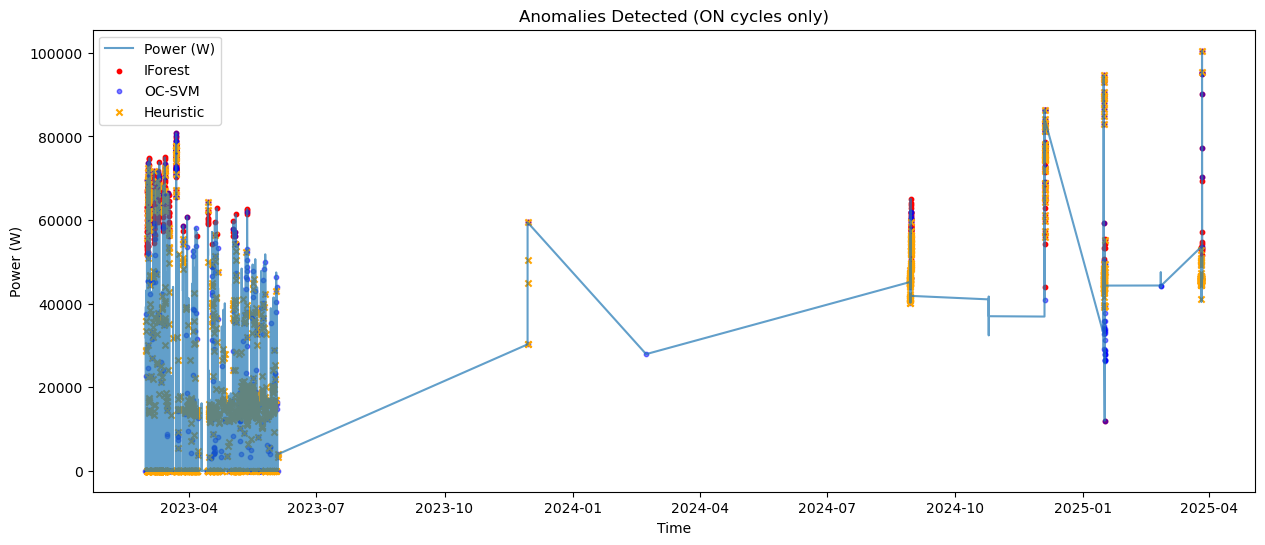

In [26]:
# --- 6. Visualize anomalies on top of power curve ---
plt.figure(figsize=(15,6))
plt.plot(df_on['time'], df_on['ptot_W'], label="Power (W)", alpha=0.7)

# Overlay anomalies
plt.scatter(df_on.loc[df_on['anomaly_iforest']==1,'time'],
            df_on.loc[df_on['anomaly_iforest']==1,'ptot_W'],
            color='red', s=10, label='IForest')

plt.scatter(df_on.loc[df_on['anomaly_ocsvm']==1,'time'],
            df_on.loc[df_on['anomaly_ocsvm']==1,'ptot_W'],
            color='blue', s=10, label='OC-SVM', alpha=0.5)

plt.scatter(df_on.loc[df_on['anomaly_heuristic']==1,'time'],
            df_on.loc[df_on['anomaly_heuristic']==1,'ptot_W'],
            color='orange', s=20, label='Heuristic', marker='x')

plt.legend()
plt.title("Anomalies Detected (ON cycles only)")
plt.xlabel("Time")
plt.ylabel("Power (W)")
plt.show()


In [27]:
# --- 7. Evaluation Proxy ---
# Since we don't have true failure logs, we can only measure overlap:
overlap_iforest_heur = (df_on['anomaly_iforest'] & df_on['anomaly_heuristic']).sum()
overlap_ocsvm_heur = (df_on['anomaly_ocsvm'] & df_on['anomaly_heuristic']).sum()

print("IForest ∩ Heuristic anomalies:", overlap_iforest_heur)
print("OCSVM ∩ Heuristic anomalies:", overlap_ocsvm_heur)


IForest ∩ Heuristic anomalies: 150
OCSVM ∩ Heuristic anomalies: 207


In [28]:
# Convert time to datetime index for grouping
df_on = df_on.set_index('time')

# Daily anomaly counts per method
daily_anomalies = df_on[['anomaly_iforest','anomaly_ocsvm','anomaly_heuristic']].resample('D').sum()

# Weekly anomaly counts per method
weekly_anomalies = df_on[['anomaly_iforest','anomaly_ocsvm','anomaly_heuristic']].resample('W').sum()

print("Daily anomalies (first 10 days):\n", daily_anomalies.head(10))
print("\nWeekly anomalies:\n", weekly_anomalies.head())


Daily anomalies (first 10 days):
                            anomaly_iforest  anomaly_ocsvm  anomaly_heuristic
time                                                                        
2023-02-28 00:00:00+00:00                0              3                  5
2023-03-01 00:00:00+00:00               24             12                  3
2023-03-02 00:00:00+00:00               73             25                 61
2023-03-03 00:00:00+00:00               48             15                 31
2023-03-04 00:00:00+00:00                0              1                  4
2023-03-05 00:00:00+00:00                0              5                  4
2023-03-06 00:00:00+00:00               53             11                 13
2023-03-07 00:00:00+00:00                1              6                  2
2023-03-08 00:00:00+00:00               38              6                 35
2023-03-09 00:00:00+00:00               42             18                 15

Weekly anomalies:
                       

<Figure size 1400x600 with 0 Axes>

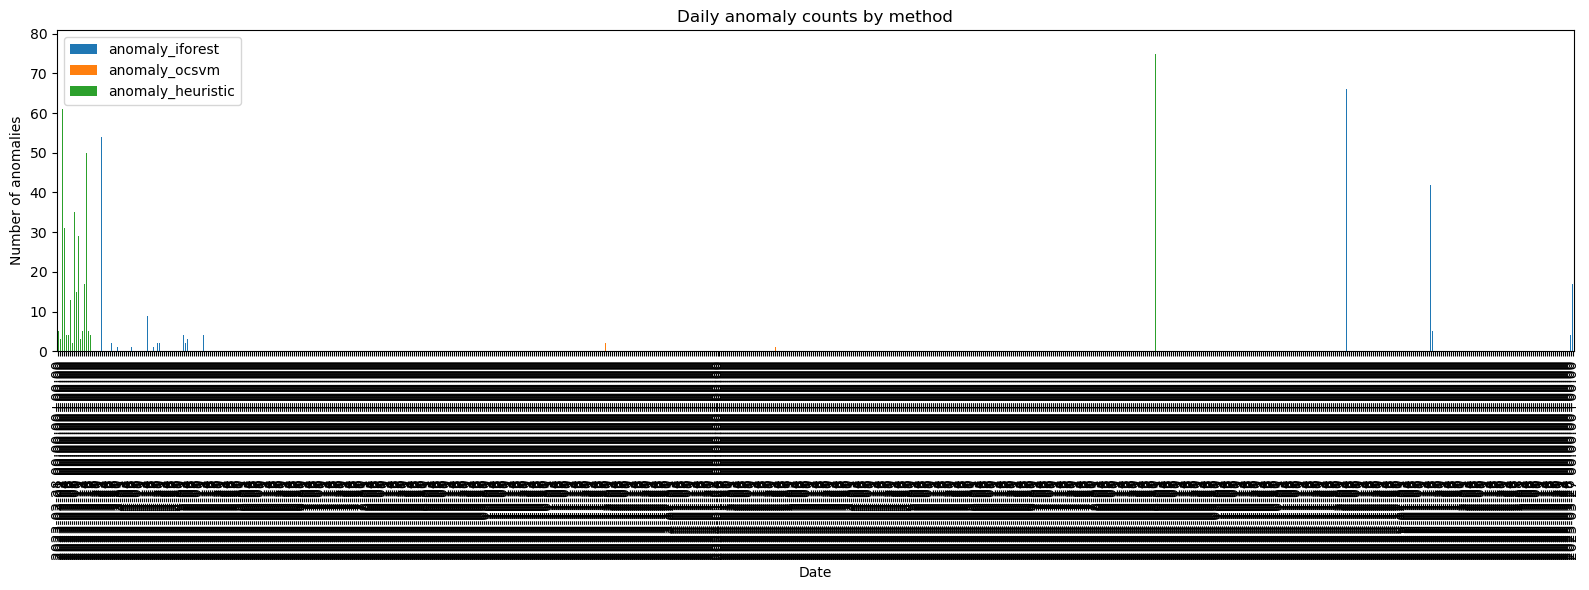

In [29]:
plt.figure(figsize=(14,6))
daily_anomalies.plot(kind='bar', stacked=False, figsize=(16,6))
plt.title("Daily anomaly counts by method")
plt.ylabel("Number of anomalies")
plt.xlabel("Date")
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

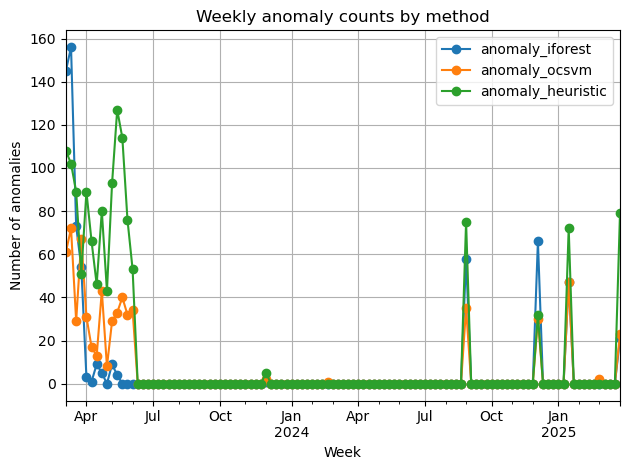

In [30]:
plt.figure(figsize=(12,6))
weekly_anomalies.plot(kind='line', marker='o')
plt.title("Weekly anomaly counts by method")
plt.ylabel("Number of anomalies")
plt.xlabel("Week")
plt.grid(True)
plt.tight_layout()
plt.show()


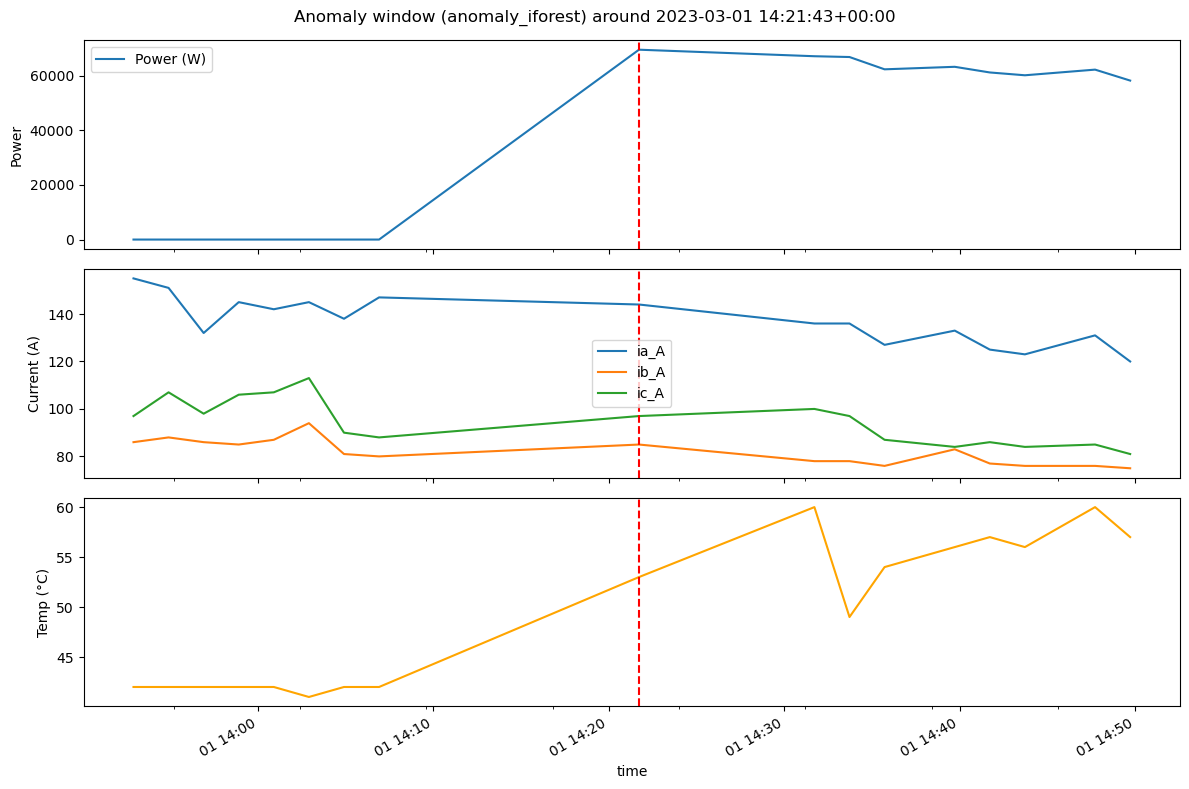

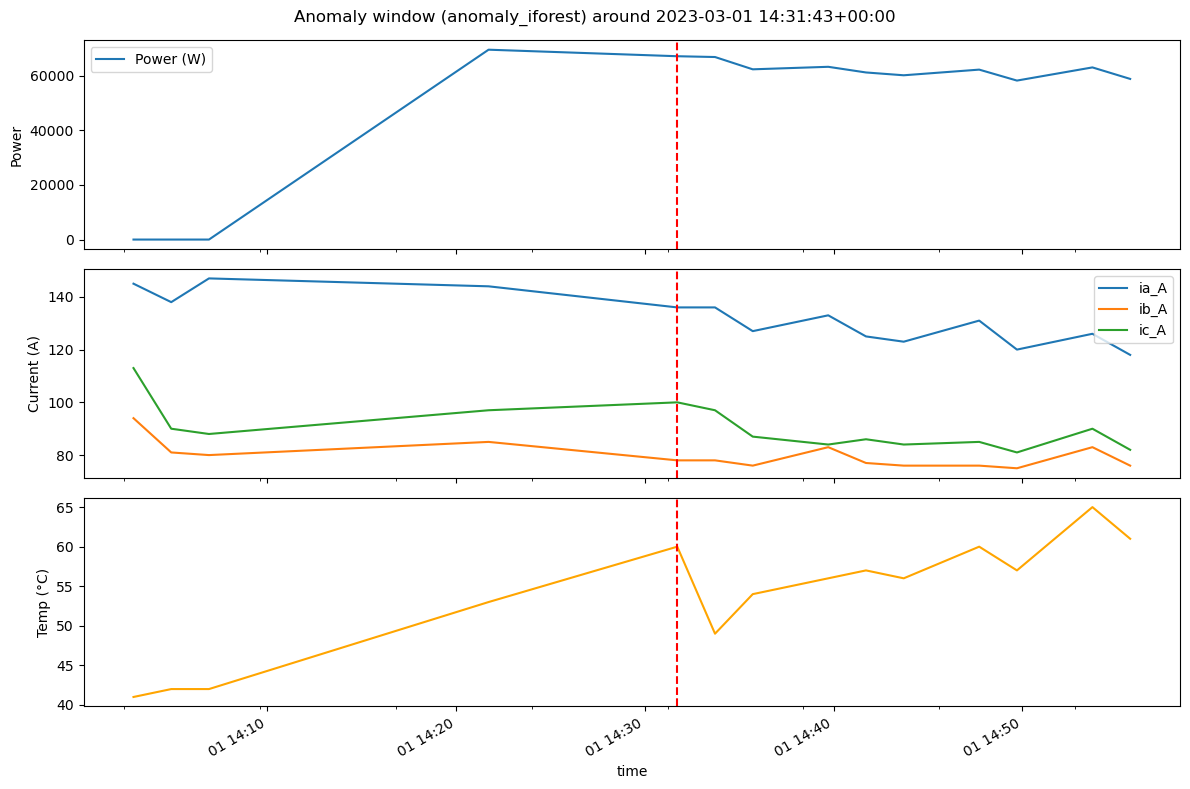

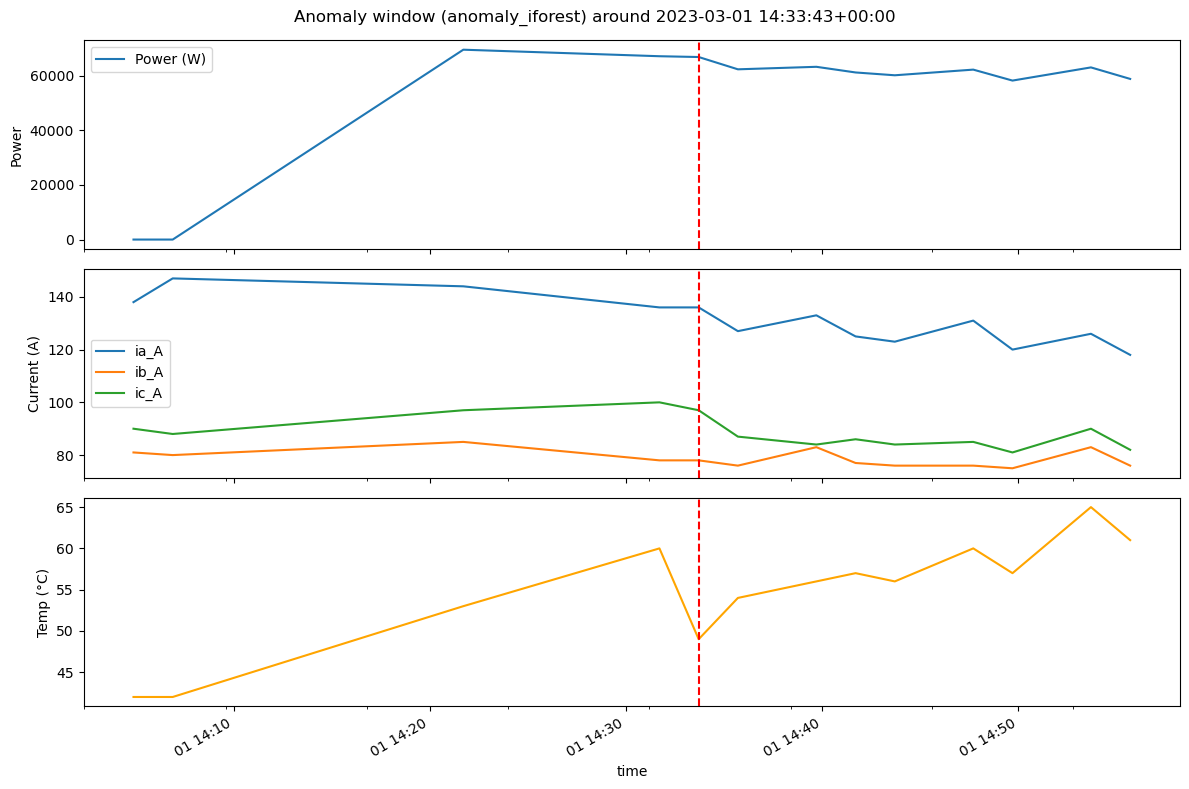

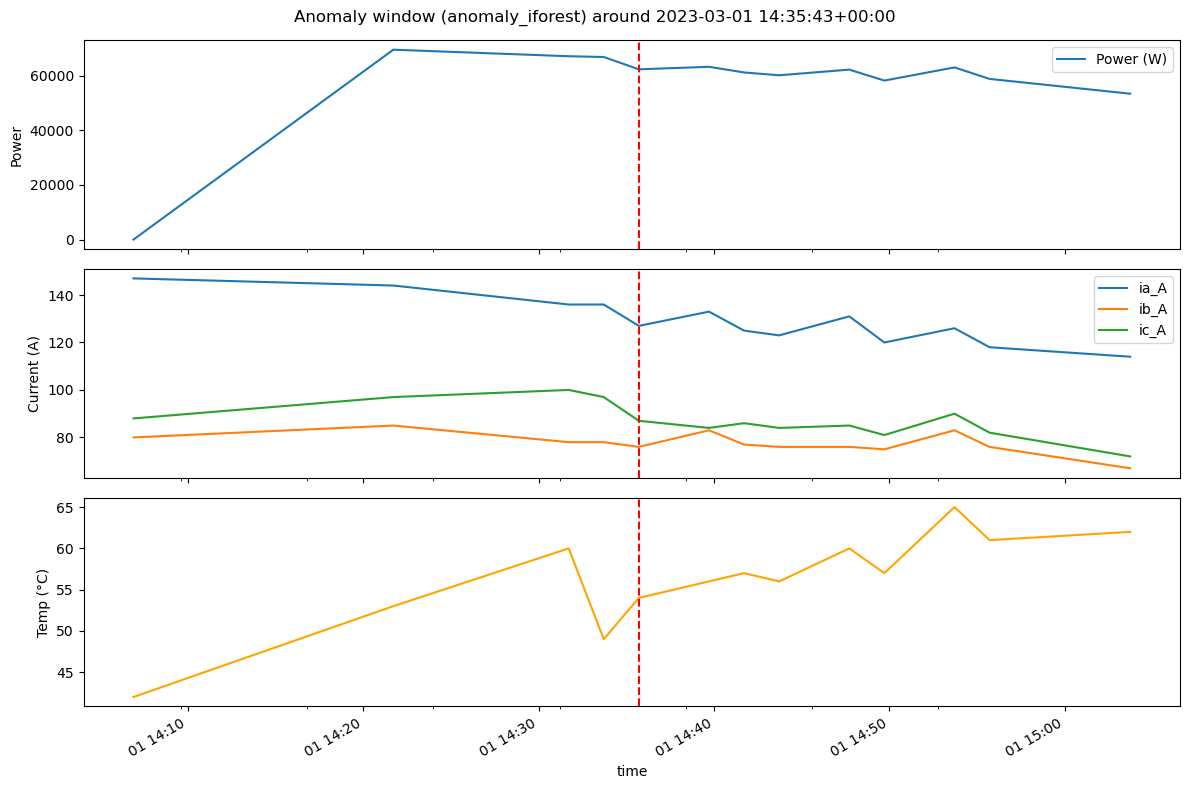

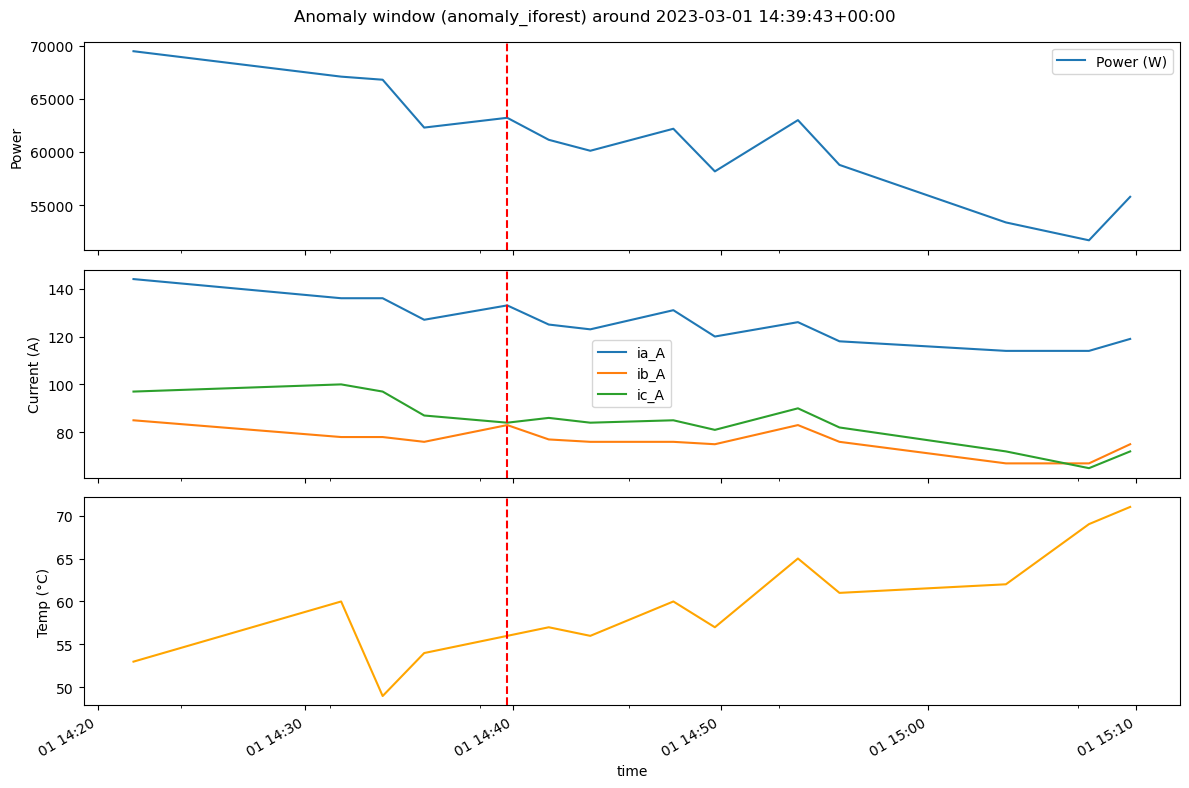

In [31]:
import matplotlib.dates as mdates

def plot_top_anomalies(df, method='anomaly_iforest', N=5, window='30min'):
    """
    Plot top N anomaly windows around detected anomalies.
    df: DataFrame with time index and anomaly columns
    method: which anomaly column to use ('anomaly_iforest', 'anomaly_ocsvm', etc.)
    N: number of anomalies to show
    window: time window around anomaly (e.g. '30min', '1h')
    """
    # Find anomaly timestamps
    anomaly_times = df.index[df[method] == 1]
    
    # If no anomalies, exit
    if len(anomaly_times) == 0:
        print(f"No anomalies found for {method}")
        return
    
    # Pick N anomalies (you can also rank by severity if available)
    selected_times = anomaly_times[:N]
    
    for t in selected_times:
        # Slice data around the anomaly
        window_df = df.loc[t - pd.Timedelta(window): t + pd.Timedelta(window)]
        
        # Plot key signals
        fig, axes = plt.subplots(3, 1, figsize=(12,8), sharex=True)
        
        window_df['ptot_W'].plot(ax=axes[0], label="Power (W)")
        axes[0].axvline(t, color='red', linestyle='--')
        axes[0].set_ylabel("Power")
        axes[0].legend()
        
        window_df[['ia_A','ib_A','ic_A']].plot(ax=axes[1])
        axes[1].axvline(t, color='red', linestyle='--')
        axes[1].set_ylabel("Current (A)")
        
        window_df['temp_Degrees Celsius'].plot(ax=axes[2], color='orange')
        axes[2].axvline(t, color='red', linestyle='--')
        axes[2].set_ylabel("Temp (°C)")
        
        plt.suptitle(f"Anomaly window ({method}) around {t}")
        plt.tight_layout()
        plt.show()

# Example usage:
plot_top_anomalies(df_on, method='anomaly_iforest', N=5, window='30min')
